# Analysis of Separator Signal After the Capacitor was fitted


In [1]:
import altair as alt
import numpy as np
import pandas as pd

from src.data_processing import create_data_from_entry, unstable_seconds, calibrate_data, flatten_data, average_data

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Raw data Analysis

First we load the data and calibrated the data to the separator PSU voltage.

In [2]:
data = pd.read_csv("C:\\Users\\olz75487\\Documents\\muonfe\\data\\processed\\2018-11-09-voltage-data-cleaned.csv", 
                   nrows=210)
calibrated_data = calibrate_data(data, 20)
calibrated_data = calibrated_data.sort_index(axis=1)

In [3]:
calibrated_data = calibrate_data(data, 20)

Now we flatten each array of data by asigning a time stamp to each element of the array in the following way:

- Given a row,  finding the time delta between this row and the next row,
- Dividing this time delta by the number of elements in an array (100 in this case) to get the time delta between readings.
- For each element of the array, multiple the time delta between readings and the position of the element in the array and add this to the time reading for the row.

Note this assumes that readings are sampled equally spaced apart.

In [4]:
flatten_raw_data = flatten_data(calibrated_data)

In [5]:
# These charts create rules to show the mean and stability limits.
raw_limits = pd.DataFrame([{
    'average': np.mean(flatten_raw_data.loc[:, "Value"]),
    'low_limit': np.mean(flatten_raw_data.loc[:, "Value"]) - 1,
    'high_limit': np.mean(flatten_raw_data.loc[:, "Value"]) + 1
}])

mean = alt.Chart(raw_limits).mark_rule(color='#09881F', opacity=0.5).encode(
    y = "average:Q",
    size=alt.value(3)
)

low_limit = alt.Chart(raw_limits).mark_rule(color='#CE270B', opacity=0.5).encode(
    y = "low_limit:Q",
    size=alt.value(3)
)

high_limit = alt.Chart(raw_limits).mark_rule(color='#CE270B', opacity=0.5).encode(
    y = "high_limit:Q",
    size=alt.value(3)
)

limits_layer = alt.layer( mean, high_limit, low_limit, data=raw_limits)

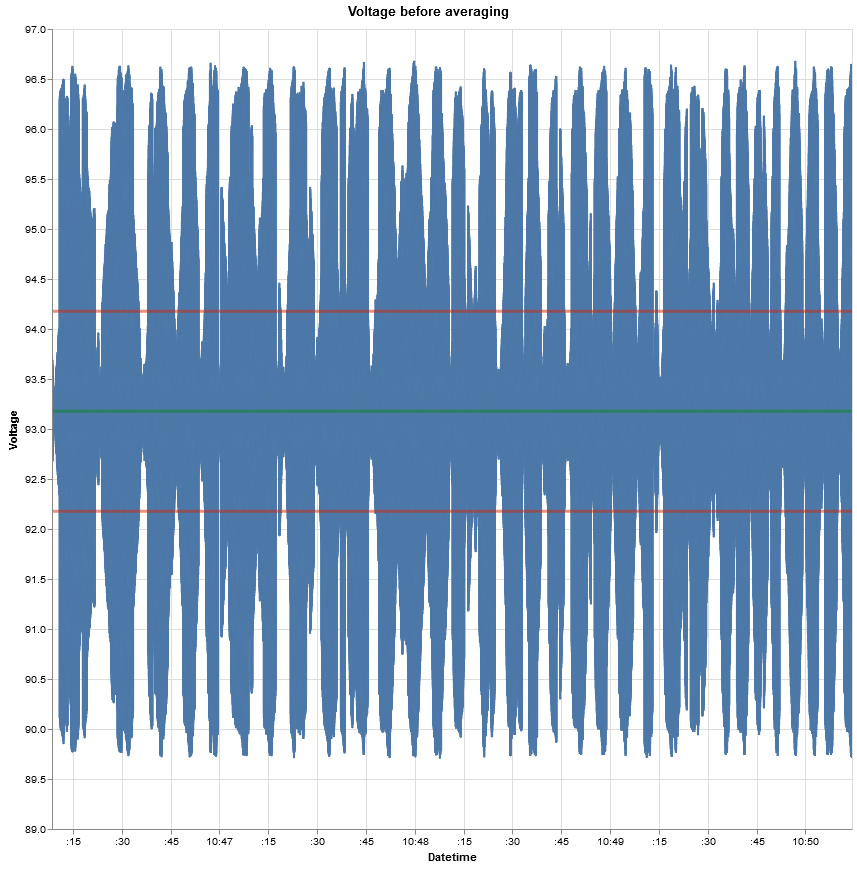

In [6]:
# Graph the line
base_line = alt.Chart().mark_line().encode(
    alt.X("Datetime:T", title="Datetime"),
    alt.Y("Value:Q", scale = alt.Scale(domain=[89, 97]), title="Voltage")
).properties(
    height = 800,
    width=800
)

raw_line = base_line.properties(title = "Voltage before averaging")

alt.layer(raw_line, limits_layer, data=flatten_raw_data).interactive()

In [7]:
raw_mean = np.mean(flatten_raw_data)
raw_mean

Value    93.176931
dtype: float64

In [8]:
raw_std = np.std(flatten_raw_data)
raw_std

Value    2.394288
dtype: float64

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $2.383439kV$ from a mean of $93.177092kV$.

In [9]:
unstable_seconds(flatten_raw_data, float(raw_mean))

161.87

The number of unstable seconds is 480.55 over this 10 minute windows. This would suggest that the signal is permanently unstable.

## Averaging the data

Now we will average the data by averaging values which are 180 degrees apart on the 50Hz wave. As this data was collected while sampling 100 elements at 100Hz (new reading every second) we need to average each pair of elements. We set the timestamp of the average to the later element's timestamp.

In [10]:
averaged_data = average_data(flatten_raw_data)

In [11]:
averaged_data_mean = np.mean(averaged_data)
averaged_data_mean

Value    93.177028
dtype: float64

In [12]:
np.std(averaged_data)

Value    0.152311
dtype: float64

In [13]:
1- np.std(averaged_data)/np.std(flatten_raw_data)

Value    0.936386
dtype: float64

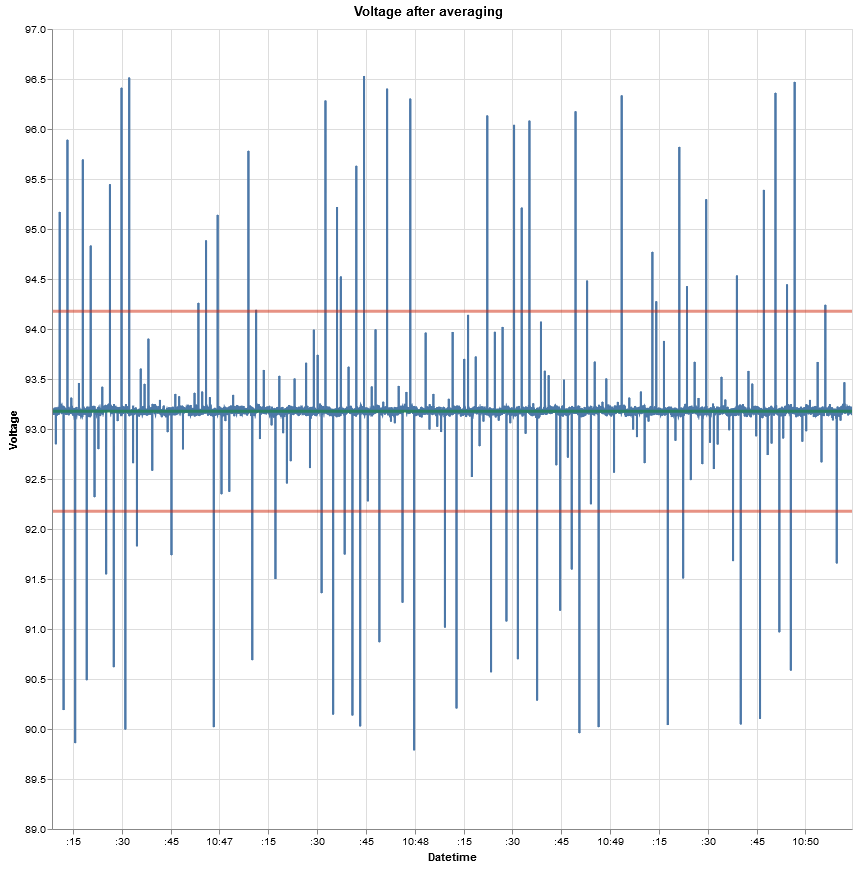

In [14]:
averaged_limits = pd.DataFrame([{
    'average': np.mean(averaged_data.loc[:, "Value"]),
    'low_limit': np.mean(averaged_data.loc[:, "Value"]) - 1,
    'high_limit': np.mean(averaged_data.loc[:, "Value"]) + 1
}])
averaged_limits_layer = alt.layer( mean, high_limit, low_limit, data=averaged_limits)

# Base line chart
averaged_line = base_line.properties( 
    title="Voltage after averaging"
)

alt.layer(averaged_line,averaged_limits_layer, data=averaged_data).interactive()

The graph above shows how often the signal is outside of the stability parameters set at $\pm1kV$ from the mean. We also see that the signal has a standard deviation of $0.151717kV$ from a mean of $93.17711652034315kV$. This is a $93.6345\%$ reduction of the standard deviation.

In [15]:
unstable_seconds(averaged_data, float(averaged_data_mean))

0.74

The number of unstable seconds is 2.07 seconds over this 10 minute windows. This falls with in the error bounds that are specified in the requirements document.